## Mounting Google Drive

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Baseline Model

## Importing Necessary Libraries


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import PIL # for displaying images
import pathlib # for loading the dataset

In [2]:
print(tf.__version__)

2.15.0


## Environment Information for Reproducibility


*   Processor architecture: Intel® Core™ i7-10750H CPU @ 2.60GHz × 12
*   Memory: 16.0 GiB
*   OS: Ubuntu 22.04.4 LTS 64-bit
*   tensorflow version: 2.15.0




## Defining Convenience Functions

In [3]:
# convenience function for plotting training accuracy vs validation accuracy
# and training loss vs validation loss graphs for given model

def plot_accuracy_and_loss_graphs(model_info):
      train_accuracy = model_info.history["accuracy"]
      validation_accuracy = model_info.history["val_accuracy"]

      train_loss = model_info.history["loss"]
      validation_loss = model_info.history["val_loss"]

      plt.figure(figsize=(8,8))
      plt.subplot(2,1,1)
      plt.plot(train_accuracy,label="Training accuracy")
      plt.plot(validation_accuracy,label="Validation accuracy")
      plt.ylabel("Accuracy")
      plt.legend(loc="lower right")
      plt.title("Training and Validation accuracy")


      plt.figure(figsize=(8,8))
      plt.subplot(2,1,2)
      plt.plot(train_loss,label="Training loss")
      plt.plot(validation_loss,label="Validation loss")
      plt.ylabel("Cross entropy loss")
      plt.xlabel("Epochs")
      plt.legend(loc="upper right")
      plt.title("Training and Validation loss")

      plt.show()

In [4]:
# convenience function for making a prediction on
# example bear image

def make_prediction(model,image_height,image_width,classes):
    # making prediction on example bear image

    bear_url = "https://www.thoughtco.com/thmb/wk2G1gZYc8QdOPnqIj8hiSH6Wmc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/getty-brown-bear-56afcf215f9b58b7d01d5195.jpg"
    bear_img_path = tf.keras.utils.get_file("Bear",origin=bear_url)

    bear_image = tf.keras.utils.load_img(
        bear_img_path,target_size=(image_height,image_width)
    )

    image_array = tf.keras.utils.img_to_array(bear_image)
    # creating batched image
    image_array = tf.expand_dims(image_array,0)

    class_predictions = model.predict(image_array)
    scores = tf.nn.softmax(class_predictions[0])
    2

    print("Image most probably belongs to {} with {:.2f} percent confidence"
          .format(classes[np.argmax(scores)],100*np.max(scores)))

## Loading the Dataset to Colab

In [7]:
import zipfile
import os

# path to my zip file
zip_file_path = "/content/drive/MyDrive/Colab Notebooks/animal-dataset.zip"
# path to extract the dataset
extracted_directory_path = "/content/drive/MyDrive/Colab Notebooks/animal-dataset"

# extracting the zip file
with zipfile.ZipFile(zip_file_path,"r") as zip_file:
  zip_file.extractall(extracted_directory_path)


## Listing Number of Images for Each Class

In [8]:
# path to directory containing subdirectories
root_directory = "/content/drive/MyDrive/Colab Notebooks/animal-dataset"
# list of subdirectories
subdirectories = ["zebra","elephant","leopard","bear"]
# dictionary to store counts of .jpeg files in each subdirectory
jpg_file_counts = {}

# traverse each subdirectory
for subdir in subdirectories:
  # obtain path to current subdirectory
  subdirectory_path = os.path.join(root_directory,"dataset",subdir)

  # count the number of .jpeg files in the subdirectory
  jpg_files = os.listdir(subdirectory_path)
  jpg_file_counts[subdir] = len(jpg_files)

# display the number of .jpeg files in each subdirectory
for subdir, jpg_count in jpg_file_counts.items():
  print(f"Number of images in '{subdir}' directory: {jpg_count}")


Number of images in 'zebra' directory: 350
Number of images in 'elephant' directory: 350
Number of images in 'leopard' directory: 350
Number of images in 'bear' directory: 350


## Creating Data Directory for Accessing Images in Subdirectories

In [9]:
data_directory = "/content/drive/MyDrive/Colab Notebooks/animal-dataset/dataset"
data_directory = pathlib.Path(data_directory)


**Example image from zebra dataset**

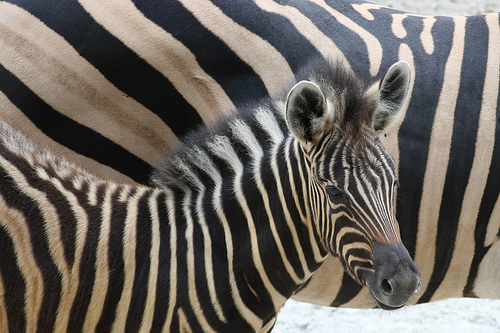

In [10]:
zebras = list(data_directory.glob("zebra/*"))
PIL.Image.open(str(zebras[0]))

**Example image from elephant dataset**

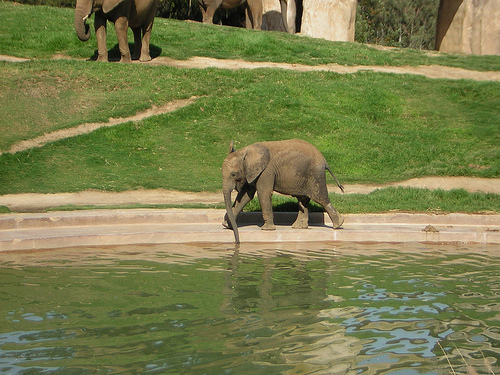

In [11]:
elephants = list(data_directory.glob("elephant/*"))
PIL.Image.open(str(elephants[0]))

**Example image from leopard dataset**

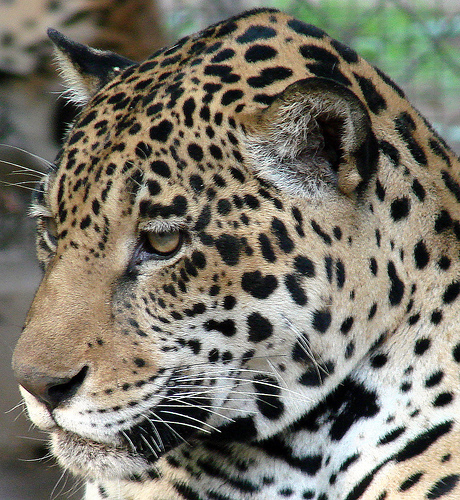

In [12]:
leopards = list(data_directory.glob("leopard/*"))
PIL.Image.open(str(leopards[0]))

**Example image from bear dataset**

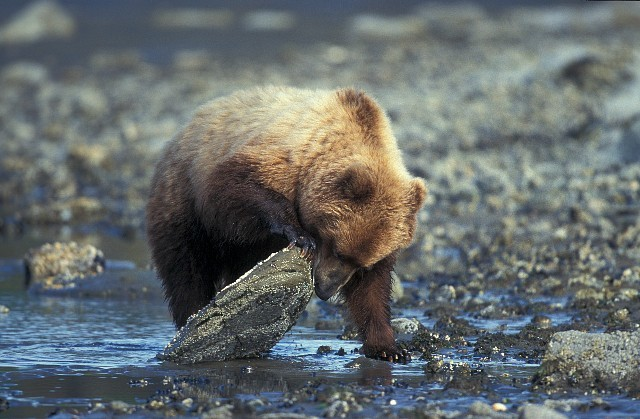

In [13]:
bears = list(data_directory.glob("bear/*"))
PIL.Image.open(str(bears[0]))

## Creating and Loading Dataset with Keras

In [14]:
batch_size = 32
image_height = 180
image_width = 180

# using 80% of the images for training
# and 20% of images for validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(image_height,image_width),
    batch_size = batch_size,
    validation_split = 0.2,
    subset="training",
    seed=123)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.


In [15]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(image_height,image_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [16]:
# we can access all the available class names
# by using class_names attribute on training dataset
# or validation dataset
classes = train_dataset.class_names
num_of_classes = len(classes)
print(classes)

['bear', 'elephant', 'leopard', 'zebra']


## Creating Keras Baseline Model

In [17]:
# RGB channel values for images are in the [0,255]
# but this is not suitable for neural network training
# we will standardize the values to be in the range [0,1]
# with the help of Rescaling layer

baseline_model = Sequential([
    layers.Rescaling(1.0/255,input_shape=(image_height,image_width,3)),
    layers.Conv2D(16,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(num_of_classes)
])

# after last convolution layer we need flattening layer to
# convert 3D tensor outputs to 1D vector and last layer should
# have same number of units as number of classes in dataset

## Compiling Constructed Baseline Model

In [18]:
baseline_model.compile(optimizer="adam",
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

## Getting the Summary of Baseline Model

In [19]:
# baseline model structure
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training baseline model

In [20]:
epochs = 10

baseline_model_info = baseline_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
35/35 [==============================] - 14s 229ms/step - loss: 1.8043 - accuracy: 0.3286 - val_loss: 1.2552 - val_accuracy: 0.3536
Epoch 2/10
35/35 [==============================] - 6s 155ms/step - loss: 0.8633 - accuracy: 0.6116 - val_loss: 0.9512 - val_accuracy: 0.6107
Epoch 3/10
35/35 [==============================] - 7s 150ms/step - loss: 0.5829 - accuracy: 0.7768 - val_loss: 0.8461 - val_accuracy: 0.6500
Epoch 4/10
35/35 [==============================] - 6s 158ms/step - loss: 0.3789 - accuracy: 0.8741 - val_loss: 0.7777 - val_accuracy: 0.7179
Epoch 5/10
35/35 [==============================] - 6s 147ms/step - loss: 0.2300 - accuracy: 0.9259 - val_loss: 0.7302 - val_accuracy: 0.7571
Epoch 6/10
35/35 [==============================] - 8s 189ms/step - loss: 0.1053 - accuracy: 0.9714 - val_loss: 0.8389 - val_accuracy: 0.7214
Epoch 7/10
35/35 [==============================] - 7s 187ms/step - loss: 0.0433 - accuracy: 0.9920 - val_loss: 0.8805 - val_accuracy: 0.7714
Epoch

## Visualizing Results After Training

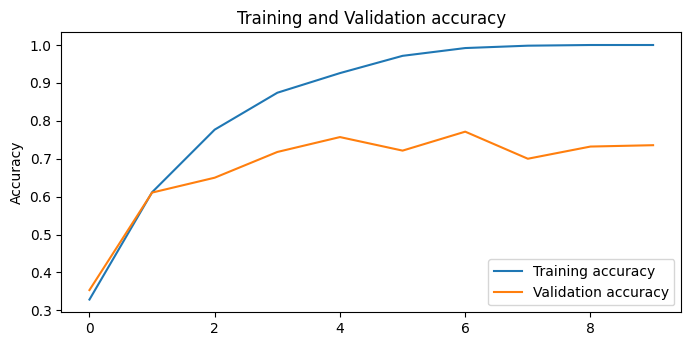

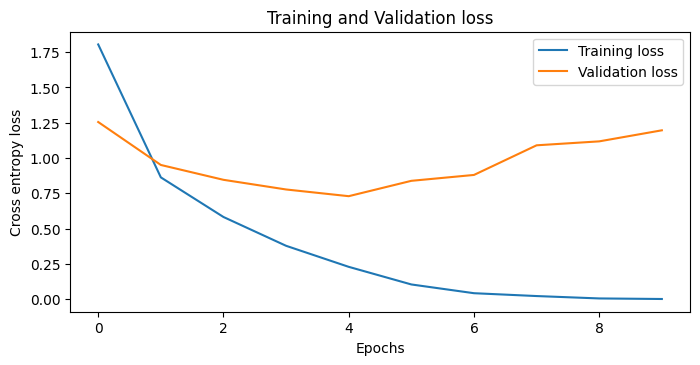

In [21]:
plot_accuracy_and_loss_graphs(baseline_model_info)

## Making Prediction on New Data

In [22]:
make_prediction(baseline_model,image_height,image_width,classes)

1/1 [==============================] - 0s 305ms/step
Image most probably belongs to bear with 96.23 percent confidence


# Experiment 1.Transfer Learning

In [23]:
# for the experiment 1 I use transfer learning
# rather than learning from scratch I use "MobileNetV2"
# which was pre-trained on ImageNet dataset
batch_size = 32
image_height = 160
image_width = 160

# creating traning and validation datasets
# for use in tansfer learning
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    seed=123,
    batch_size=batch_size,
    image_size=(image_height,image_width),
    validation_split=0.2,
    subset="training"
)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.


In [24]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    seed=123,
    batch_size=batch_size,
    image_size=(image_height,image_width),
    validation_split=0.2,
    subset="validation"
)

Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [25]:
# I use buffered prefetching to load images from disk
# without having blocking I/O
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [26]:
# MobileNetV2 model expects pixel values to be in range [-1,1]
# but our pixel values in our images are in [0,255]. I use
# preprocessing method included with the model to rescale them

preprocess_layer = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (160,160,3),
    include_top = False,
    weights = "imagenet"
)

# I follow the common practice that when using pre-trained models
# take the layers up until the layer that performs flatten operation
# as the last layer that comes before the flatten layer retain
# more generality as compared to final layer2

9406464/9406464 [==============================] - 0s 0us/step


In [28]:
# I use the pre-trained MobileNetV2 model as a feature extractor
image_batch, label_batch = next(iter(train_dataset))
feature_batch = pretrained_model(image_batch)
print(f"feature batch shape is {feature_batch.shape}")

feature batch shape is (32, 5, 5, 1280)


In [29]:
# now I freeze the convolutional base of pre-trained model
# in order to prevent weights in a given layer from being updated
# during training phase
pretrained_model.trainable = False

In [30]:
# arcitecture of pretrained model is as follows
pretrained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [31]:
# in order to generate predictions from features, I apply global average pooling,
# to convert features into 1D vector for each image
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
averaged_feature_batch = global_average_pooling_layer(feature_batch)
print(f"averaged feature batch shape is {averaged_feature_batch.shape}")

averaged feature batch shape is (32, 1280)


In [32]:
# now I add fully connected (dense) layer in order to convert
# features into predictions for images

prediction_layer = tf.keras.layers.Dense(num_of_classes,activation="relu")

In [33]:
# now I build the model by putting all the necessary layers together
input_layer = tf.keras.Input(shape=(160,160,3))
intermediate_output = preprocess_layer(input_layer)
intermediate_output = pretrained_model(intermediate_output,training=False)
intermediate_output = global_average_pooling_layer(intermediate_output)
outcomes = prediction_layer(intermediate_output)
composed_model = tf.keras.Model(input_layer,outcomes)

In [34]:
# composed model's architecture is as follows
composed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [35]:
# now I compile the model to make model ready for training
default_learning_rate = 0.0001

composed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=default_learning_rate),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])


In [36]:
# training th model for 10 epochs
epochs = 10

composed_model_info = composed_model.fit(train_dataset,
                                         epochs=epochs,
                                         validation_data=validation_dataset)

Epoch 1/10
35/35 [==============================] - 13s 239ms/step - loss: 1.3149 - accuracy: 0.3714 - val_loss: 1.1656 - val_accuracy: 0.5179
Epoch 2/10
35/35 [==============================] - 6s 142ms/step - loss: 1.0239 - accuracy: 0.6500 - val_loss: 0.9246 - val_accuracy: 0.6536
Epoch 3/10
35/35 [==============================] - 7s 144ms/step - loss: 0.7782 - accuracy: 0.7589 - val_loss: 0.7450 - val_accuracy: 0.7179
Epoch 4/10
35/35 [==============================] - 6s 158ms/step - loss: 0.5849 - accuracy: 0.8580 - val_loss: 0.5126 - val_accuracy: 0.9179
Epoch 5/10
35/35 [==============================] - 6s 143ms/step - loss: 0.3737 - accuracy: 0.9705 - val_loss: 0.3172 - val_accuracy: 0.9643
Epoch 6/10
35/35 [==============================] - 7s 181ms/step - loss: 0.2474 - accuracy: 0.9929 - val_loss: 0.2306 - val_accuracy: 0.9786
Epoch 7/10
35/35 [==============================] - 6s 144ms/step - loss: 0.1822 - accuracy: 0.9929 - val_loss: 0.1814 - val_accuracy: 0.9786
Epoch

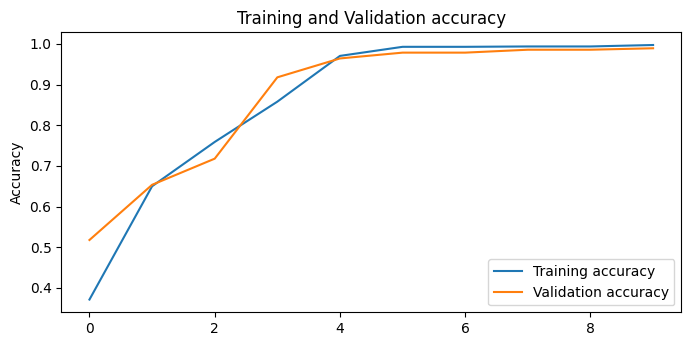

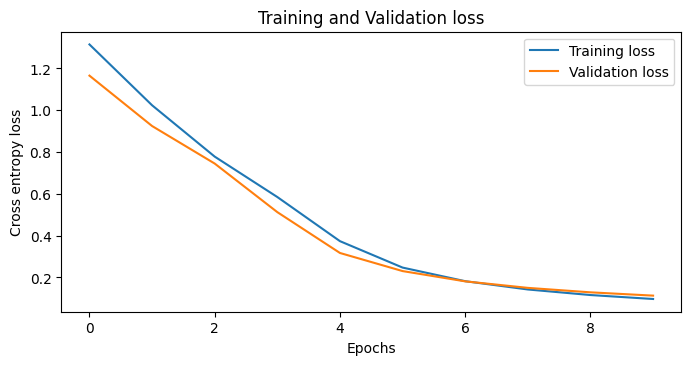

In [37]:
plot_accuracy_and_loss_graphs(composed_model_info)

In [38]:
make_prediction(composed_model,image_height,image_width,classes)

1/1 [==============================] - 1s 1s/step
Image most probably belongs to bear with 94.71 percent confidence


# Experiment 2.Using Different Architecture

In [39]:
# for the experiment 2 I use different
# architecture which is VGG16

# I follow the common practice that when using pre-trained models
# take the layers up until the layer that performs flatten operation.
# As the last layer that comes before the flatten layer retain
# more generality as compared to final layer

pretrained_vgg16_model = tf.keras.applications.VGG16(
    input_shape = (160,160,3),
    include_top = False,
    weights = "imagenet"
)

58889256/58889256 [==============================] - 0s 0us/step


In [40]:
# I use the pre-trained VGG16 architecture as a feature extractor

image_batch, label_batch = next(iter(train_dataset))
feature_batch = pretrained_vgg16_model(image_batch)
print(f"feature batch shape is {feature_batch.shape}")

feature batch shape is (32, 5, 5, 512)


In [41]:
# Similar to what I did in experiment 1 on transfer learning
# I freeze the convolutional base of pre-trained vgg16 model in
# order to prevent weights in a given layer from being updated during
# training phase

pretrained_vgg16_model.trainable = False

In [42]:
# arcitecture of pretrained vgg16 model is as follows

pretrained_vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [43]:
# in order to generate predictions from features, I apply global average pooling,
# to convert features into 1D vector for each image

global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
averaged_feature_batch = global_average_pooling_layer(feature_batch)
print(f"averaged feature batch shape is {averaged_feature_batch.shape}")

averaged feature batch shape is (32, 512)


In [44]:
# now I add fully connected (dense) layer in order to convert
# features into predictions for images

prediction_layer = tf.keras.layers.Dense(num_of_classes,activation="relu")

In [45]:
# now I build the model by putting all the necessary layers togethers
input_layer = tf.keras.Input(shape=(160,160,3))
intermediate_output = tf.keras.layers.Rescaling(1.0/255)(input_layer)
intermediate_output = pretrained_vgg16_model(intermediate_output,training=False)
intermediate_output = global_average_pooling_layer(intermediate_output)
outcomes = prediction_layer(intermediate_output)
finetuned_vgg16_model = tf.keras.Model(input_layer,outcomes)

In [46]:
# fine-tuned vgg16 architecture is as follows
finetuned_vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14716740 (56.14 MB)
Trainable params: 2052 (8.02 KB)
Non-trainable params: 14714688 (56.13 MB)
________________

In [47]:
# now I compile the model to make model ready for training
default_learning_rate = 0.0001

finetuned_vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=default_learning_rate),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])


In [48]:
# training fine-tuned vgg16 model for 10 epochs
epochs = 10

finetuned_vgg16_model_info = finetuned_vgg16_model.fit(train_dataset,
                                         epochs=epochs,
                                         validation_data=validation_dataset)

Epoch 1/10
35/35 [==============================] - 16s 293ms/step - loss: 1.3633 - accuracy: 0.3652 - val_loss: 1.3326 - val_accuracy: 0.4286
Epoch 2/10
35/35 [==============================] - 7s 166ms/step - loss: 1.3438 - accuracy: 0.4241 - val_loss: 1.3226 - val_accuracy: 0.4321
Epoch 3/10
35/35 [==============================] - 10s 250ms/step - loss: 1.3310 - accuracy: 0.4411 - val_loss: 1.3107 - val_accuracy: 0.4536
Epoch 4/10
35/35 [==============================] - 7s 166ms/step - loss: 1.3199 - accuracy: 0.4491 - val_loss: 1.2990 - val_accuracy: 0.4571
Epoch 5/10
35/35 [==============================] - 7s 159ms/step - loss: 1.3092 - accuracy: 0.4554 - val_loss: 1.2874 - val_accuracy: 0.4786
Epoch 6/10
35/35 [==============================] - 8s 208ms/step - loss: 1.2988 - accuracy: 0.4571 - val_loss: 1.2768 - val_accuracy: 0.4821
Epoch 7/10
35/35 [==============================] - 7s 170ms/step - loss: 1.2888 - accuracy: 0.4652 - val_loss: 1.2668 - val_accuracy: 0.4857
Epoc

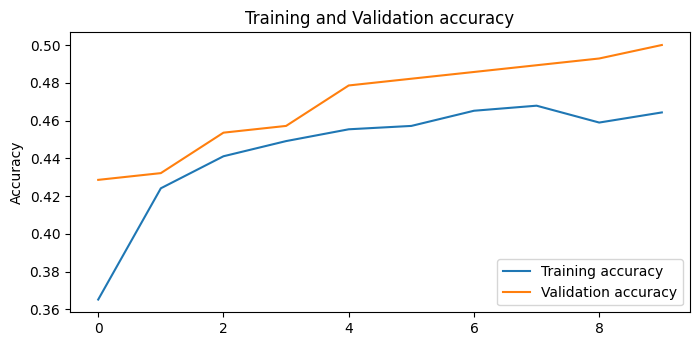

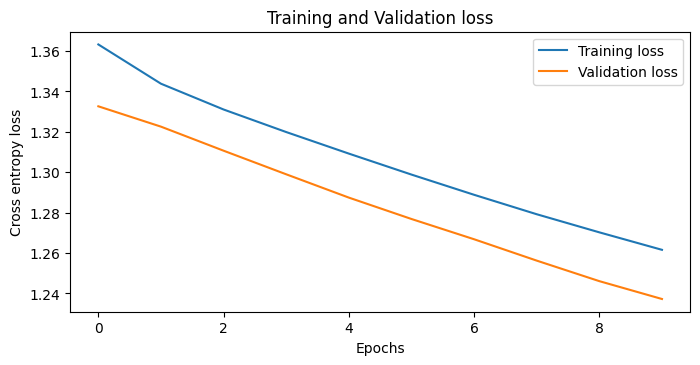

In [50]:
plot_accuracy_and_loss_graphs(finetuned_vgg16_model_info)

In [51]:
make_prediction(finetuned_vgg16_model,image_height,image_width,classes)

1/1 [==============================] - 1s 1s/step
Image most probably belongs to elephant with 27.61 percent confidence


# Experiment 3.Data Augmentation

In [52]:
# for the experiment 3 I use
# data augmentation via common
# preprocessing options such as
# rotating, flipping, or zooming images

batch_size = 32
image_height = 180
image_width = 180

# creating training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(image_height,image_width),
    batch_size = batch_size,
    validation_split = 0.2,
    subset="training",
    seed=123)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.


In [53]:
# creating validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(image_height,image_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [54]:
# creating data augmentation layer
data_augmentation_layer = tf.keras.Sequential([
      layers.RandomFlip("horizontal",input_shape=(image_height,
                                             image_width,
                                             3)),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2)
])

In [56]:
# I created a modified model by adding
# data augmentation layer to baseline mode

data_augmented_model = Sequential([
    data_augmentation_layer, # adding data augmentation layer
    layers.Rescaling(1.0/255),
    layers.Conv2D(16,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(num_of_classes,name="outputs")
])

In [57]:
# compiling model after addition of
# data augmentation layer

data_augmented_model.compile(optimizer="adam",
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

In [58]:
# modified CNN structure after additon of
# data augmentation layer
data_augmented_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [59]:
# training the CNN after addition of
# data augmentation layer
epochs = 10
data_augmented_model_info = data_augmented_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
35/35 [==============================] - 10s 186ms/step - loss: 1.4093 - accuracy: 0.3402 - val_loss: 1.6227 - val_accuracy: 0.3071
Epoch 2/10
35/35 [==============================] - 6s 142ms/step - loss: 1.0580 - accuracy: 0.5152 - val_loss: 0.9962 - val_accuracy: 0.6036
Epoch 3/10
35/35 [==============================] - 7s 179ms/step - loss: 0.9331 - accuracy: 0.5750 - val_loss: 1.1225 - val_accuracy: 0.5643
Epoch 4/10
35/35 [==============================] - 6s 142ms/step - loss: 0.8205 - accuracy: 0.6661 - val_loss: 1.0217 - val_accuracy: 0.6071
Epoch 5/10
35/35 [==============================] - 7s 179ms/step - loss: 0.7642 - accuracy: 0.6804 - val_loss: 1.6678 - val_accuracy: 0.5071
Epoch 6/10
35/35 [==============================] - 6s 143ms/step - loss: 0.7079 - accuracy: 0.7250 - val_loss: 1.0812 - val_accuracy: 0.5964
Epoch 7/10
35/35 [==============================] - 7s 181ms/step - loss: 0.6695 - accuracy: 0.7143 - val_loss: 0.8757 - val_accuracy: 0.6786
Epoch

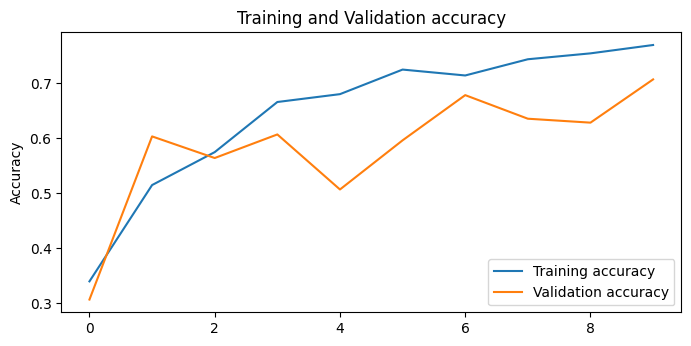

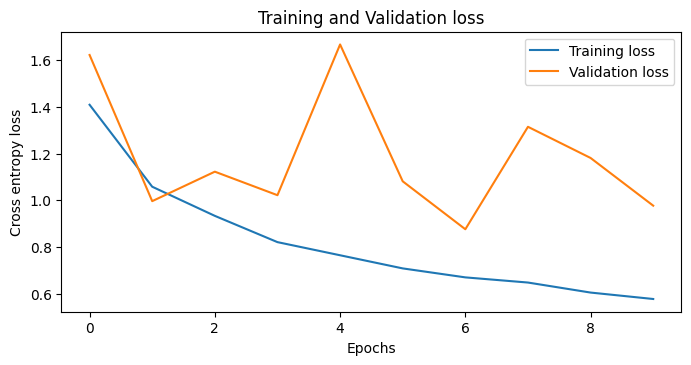

In [60]:
plot_accuracy_and_loss_graphs(data_augmented_model_info)

In [61]:
make_prediction(data_augmented_model,image_height,image_width,classes)

1/1 [==============================] - 0s 128ms/step
Image most probably belongs to leopard with 52.27 percent confidence


# Experiment 4.Regularization with Dropout

In [62]:
# for the experiment 4 I use
# droput out regularization
# to reduce chance of overfitting

# I created a modified model by adding
# dropout layer to baseline mode

dropout_model = Sequential([
    layers.Rescaling(1.0/255,input_shape=(image_height,image_width,3)),
    layers.Conv2D(16,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # adding Dropout layer
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(num_of_classes,name="outputs")
])


In [63]:
# compiling model after addition of
# dropout layer

dropout_model.compile(optimizer="adam",
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

In [64]:
# modified CNN structure after additon of
# dropout layer

dropout_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [65]:
# training the CNN after addition of
# droput layer

epochs = 10
dropout_model_info = dropout_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
35/35 [==============================] - 10s 188ms/step - loss: 1.1478 - accuracy: 0.4679 - val_loss: 0.9329 - val_accuracy: 0.6607
Epoch 2/10
35/35 [==============================] - 6s 144ms/step - loss: 0.7071 - accuracy: 0.7268 - val_loss: 0.7706 - val_accuracy: 0.7071
Epoch 3/10
35/35 [==============================] - 7s 173ms/step - loss: 0.5952 - accuracy: 0.7527 - val_loss: 0.7260 - val_accuracy: 0.7214
Epoch 4/10
35/35 [==============================] - 6s 142ms/step - loss: 0.4226 - accuracy: 0.8295 - val_loss: 0.6500 - val_accuracy: 0.7714
Epoch 5/10
35/35 [==============================] - 7s 176ms/step - loss: 0.3043 - accuracy: 0.8893 - val_loss: 0.8330 - val_accuracy: 0.7321
Epoch 6/10
35/35 [==============================] - 8s 192ms/step - loss: 0.2028 - accuracy: 0.9339 - val_loss: 0.7133 - val_accuracy: 0.7464
Epoch 7/10
35/35 [==============================] - 6s 146ms/step - loss: 0.1447 - accuracy: 0.9554 - val_loss: 0.6839 - val_accuracy: 0.7750
Epoch

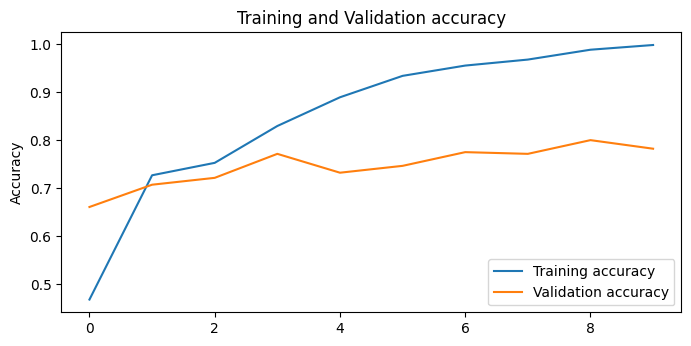

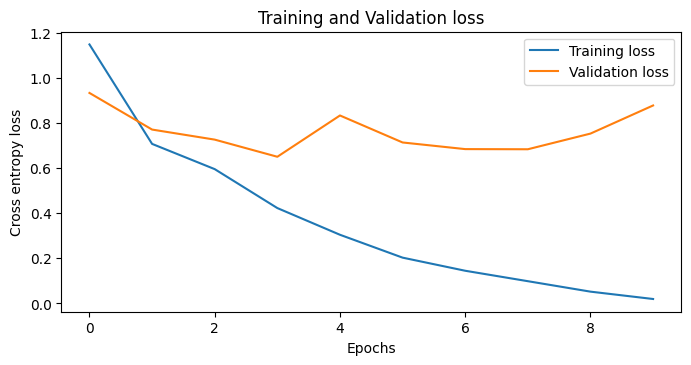

In [66]:
plot_accuracy_and_loss_graphs(dropout_model_info)

In [71]:
make_prediction(dropout_model,image_height,image_width,classes)

1/1 [==============================] - 0s 23ms/step
Image most probably belongs to bear with 99.01 percent confidence


# Experiment 5.Using Different Hyperparameters

In [72]:
# for the experiment 5 I change the
# CNN to contain 3 more convolution
# and max pooling layers, I changed kernel size to 5x5
# I also enable caching and prefetching

# I create model for the modified CNN hyperparameters
# I have added three more convolution and max pooling
# layers

modified_hyperparameters_model = Sequential([
    layers.Rescaling(1.0/255,input_shape=(image_height,image_width,3)),
    layers.Conv2D(16,5,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,5,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64,5,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128,5,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(256,5,padding="same",activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512,activation="relu"),
    layers.Dense(num_of_classes)
])

In [73]:
# modified CNN structure
modified_hyperparameters_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      1216      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        12832     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [74]:
# compiling modified hyperparameter model

modified_hyperparameters_model.compile(optimizer="adam",
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

In [75]:
# modified CNN structure after changing
# number of convolution and max pooling layers
# and kernel size hyperparameters
data_augmented_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [76]:
# training the CNN with modified hyperparameters
epochs = 10
modified_hyperparameters_model_info = modified_hyperparameters_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
35/35 [==============================] - 12s 198ms/step - loss: 1.3945 - accuracy: 0.2991 - val_loss: 1.2362 - val_accuracy: 0.4321
Epoch 2/10
35/35 [==============================] - 7s 147ms/step - loss: 1.0866 - accuracy: 0.4750 - val_loss: 1.0078 - val_accuracy: 0.5107
Epoch 3/10
35/35 [==============================] - 7s 186ms/step - loss: 0.9368 - accuracy: 0.5643 - val_loss: 0.9337 - val_accuracy: 0.6357
Epoch 4/10
35/35 [==============================] - 6s 145ms/step - loss: 0.8282 - accuracy: 0.6313 - val_loss: 0.9015 - val_accuracy: 0.6321
Epoch 5/10
35/35 [==============================] - 7s 182ms/step - loss: 0.7552 - accuracy: 0.6554 - val_loss: 0.7811 - val_accuracy: 0.6679
Epoch 6/10
35/35 [==============================] - 6s 144ms/step - loss: 0.6625 - accuracy: 0.7223 - val_loss: 0.8302 - val_accuracy: 0.6429
Epoch 7/10
35/35 [==============================] - 6s 146ms/step - loss: 0.5504 - accuracy: 0.7643 - val_loss: 0.6900 - val_accuracy: 0.7321
Epoch

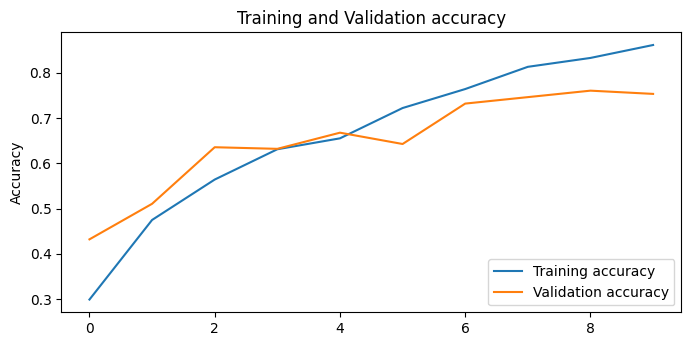

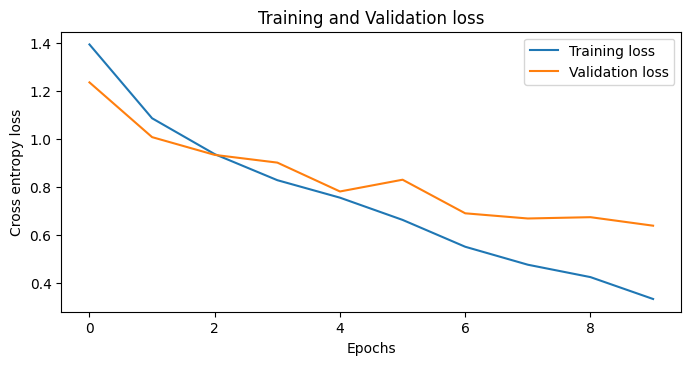

In [77]:
plot_accuracy_and_loss_graphs(modified_hyperparameters_model_info)

In [80]:
make_prediction(modified_hyperparameters_model,image_height,image_width,classes)

1/1 [==============================] - 0s 21ms/step
Image most probably belongs to bear with 77.91 percent confidence


# Proposed Model

In [105]:
# According to outcomes from previous
# modified models, I decided to combine
# my transfer learning model which uses MobileNetV2
# pre-trained model along with data augmentation
# and dropout because transfer learning model has very
# high training and validation accuracies, also
# data augmentation and dropout allows better generalization

batch_size = 32
image_height = 160
image_width = 160

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(image_height,image_width),
    batch_size = batch_size,
    validation_split = 0.2,
    subset="training",
    seed=123)

Found 1400 files belonging to 4 classes.
Using 1120 files for training.


In [106]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(image_height,image_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 1400 files belonging to 4 classes.
Using 280 files for validation.


In [107]:
# I use buffered prefetching to load images from disk
# without having blocking I/O

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [108]:
# creating data augmentation layer matching
# the image height and image width
data_augmentation_layer = tf.keras.Sequential([
      layers.RandomFlip("horizontal",input_shape=(image_height,
                                             image_width,
                                             3)),
      layers.RandomRotation(0.2),
      layers.RandomZoom(0.2)
])

In [109]:
# now I build my proposed model by putting all the necessary layers together

input_layer = tf.keras.Input(shape=(160,160,3))
intermediate_output = preprocess_layer(input_layer)
intermediate_output = data_augmentation_layer(intermediate_output)
intermediate_output = pretrained_model(intermediate_output,training=False)
intermediate_output = layers.Dropout(0.2)(intermediate_output)
intermediate_output = global_average_pooling_layer(intermediate_output)
intermediate_output = layers.Dense(512,activation="relu")(intermediate_output)
outcomes = prediction_layer(intermediate_output)
proposed_model = tf.keras.Model(input_layer,outcomes)

In [110]:
# proposed model's architecture is as follows
proposed_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [111]:
# now I compile the proposed model to make model ready for training
default_learning_rate = 0.0001

proposed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=default_learning_rate),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])


In [112]:
# training my proposed model for 10 epochs
epochs = 10

proposed_model_info = proposed_model.fit(train_dataset,
                                         epochs=epochs,
                                         validation_data=validation_dataset)

Epoch 1/10
35/35 [==============================] - 13s 211ms/step - loss: 0.8443 - accuracy: 0.6777 - val_loss: 0.2023 - val_accuracy: 0.9857
Epoch 2/10
35/35 [==============================] - 6s 146ms/step - loss: 0.1450 - accuracy: 0.9571 - val_loss: 0.0614 - val_accuracy: 0.9929
Epoch 3/10
35/35 [==============================] - 8s 212ms/step - loss: 0.0761 - accuracy: 0.9768 - val_loss: 0.0438 - val_accuracy: 0.9893
Epoch 4/10
35/35 [==============================] - 6s 143ms/step - loss: 0.0577 - accuracy: 0.9821 - val_loss: 0.0418 - val_accuracy: 0.9893
Epoch 5/10
35/35 [==============================] - 6s 144ms/step - loss: 0.0512 - accuracy: 0.9839 - val_loss: 0.0381 - val_accuracy: 0.9893
Epoch 6/10
35/35 [==============================] - 7s 183ms/step - loss: 0.0500 - accuracy: 0.9857 - val_loss: 0.0383 - val_accuracy: 0.9893
Epoch 7/10
35/35 [==============================] - 7s 176ms/step - loss: 0.0454 - accuracy: 0.9875 - val_loss: 0.0349 - val_accuracy: 0.9929
Epoch

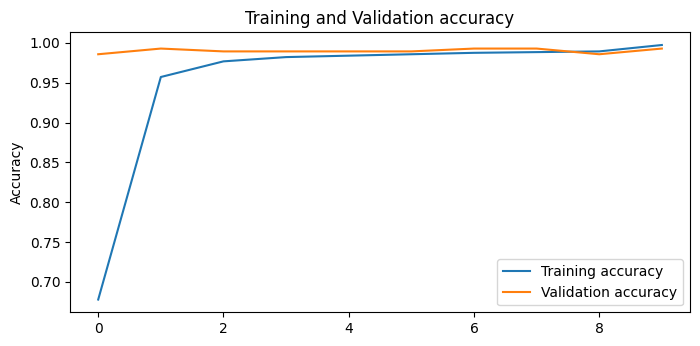

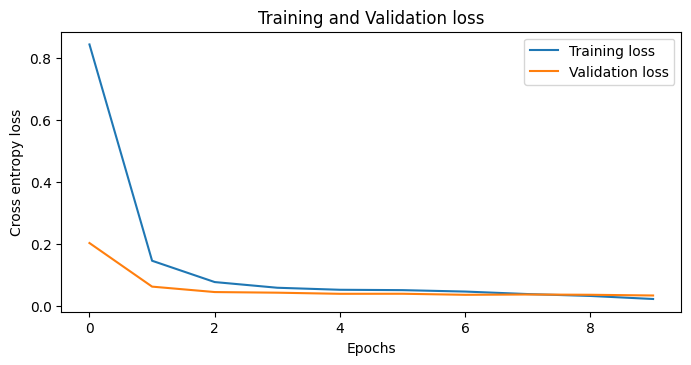

In [113]:
plot_accuracy_and_loss_graphs(proposed_model_info)

In [114]:
make_prediction(proposed_model,image_height,image_width,classes)

1/1 [==============================] - 1s 772ms/step
Image most probably belongs to bear with 99.48 percent confidence


# Conclusions

## Baseline Findings and Comments
Baseline model is explicitly **overfitting**, baseline model has the following outcomes:

---
*   training accuracy: 1.000
*   validation accuracy: 0.7357
---
*   training loss: 0.0024
*   validation loss: 1.1965
---
As it can also be seen in the graphs for
accuracy and loss there is a big discrepancy
between training and validation datasets.







## Transfer Learning Findings and Comments
I used MobileNetV2 in in my transfer learning model for fine-tuning. Oberved training and validation accuracies are both high and losses are small as it was pre-trained on a large imagenet dataset and I have fine tunned it by adding classification head for our animal dataset outcomes are as follows:

---
*  training accuracy: 0.9973
*  validation accuracy: 0.9893
---
*  training loss: 0.0971
*  validation loss:  0.1132
---
As it can be seen in the graphs for accuracy and loss, training and validation accuracies also training and validation losses converges.

## Using Different Architecture Findings and Comments
I used VGG16 architecture as a different architecture for training, training accuracy has decreased, and training loss has increased significantly compared to baseline model. Outcomes are as follows:

---
*  training accuracy: 0.4643
*  validation accuracy: 0.5000
---
*  training loss: 1.2616
*  validation loss: 1.2372
---
Also when I compare the MobileNetV2 which I used in transfer learning experiment with VGG16 I can see that MobileNetV2 performed better than VGG16 for our animal dataset.

## Data Augmentation Findings and Comments
After applying data augmentation to baseline model discrepancy between training accuracy and validation accuracy values diminished. Outcomes after data augmentation  applied are as follows:

---
*  training accuracy: 0.7796
*  validation accuracy:  0.7071
---
*  training loss: 0.5758
*  validation loss: 0.9768
---
Even though difference between training accuracy and validation accuracy decreased training loss has increased considerably compared to baseline model.


## Regularization with Dropout Findings and Comments
After applying dropout to baseline model discrepancy between training accuracy/loss and validation accuracy/loss values diminished. Outcomes after dropout applied are as follows:

---
*  training accuracy: 0.9982
*  validation accuracy: 0.7821
---
*  training loss: 0.0195
*  validation loss: 0.8774
---
Difference between training accuracy and validation accuracy decreased, while validation loss has decreased, training loss has increased compared to baseline model.



## Using Different Hyperparameters Findings and Comments
After adding three more convolution and max pooling layers and setting kernel size to 5x5 rather than 3x3, discrepancy between training and validation accuracy decreased compared to baseline model. Outcomes after using different hyperparameters are as follows:  

---
*  training accuracy: 0.8616
*  validation accuracy: 0.7536
---
*  training loss: 0.3325
*  validation loss: 0.6383
---
Even though validation loss decreased,
training loss has increased considerably
compared to baseline model.



## Proposed Model Findings and Comments
Based on the all 5 experiments I have done, I have combined MobileNetV2 pre-trained model which I have used in transfer learning along with data augmentation, droput regularization.
Outcomes are as follows:  

---
*  training accuracy: 0.9973
*  validation accuracy: 0.9929
---
*  training loss: 0.0214
*  validation loss: 0.0327
---
Prediction made on example image has predicted bear image with  99.48 percent confidence. It performed better than all other models that I have trained in 5 experiments.

